In [1]:
import pandas as pd

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Models
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR



## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import shap

## Customized functions
import importlib
import utilities
importlib.reload(utilities)
from utilities import *

In [2]:
#Loading the cleaned data
df2 = pd.read_csv('df12.csv')


In [4]:
# Select target columns

from sklearn.discriminant_analysis import StandardScaler


target_column ='responder_6'
X = df2.drop([col for col in df2.columns if 'responder_' in col] + ['date_id', 'time_id', 'symbol_id', 'weight'], axis=1)
y = df2[target_column]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize features for better PCA performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Apply PCA (keep top 20 components)
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [5]:

# Train Optimized Random Forest Regression Model
rf_model = RandomForestRegressor(
    n_estimators=20,        # Number of trees
    max_depth=15,            # Limit tree depth to prevent overfitting
    min_samples_split=10,    # Minimum samples needed to split a node
    min_samples_leaf=5,      # Minimum samples required at each leaf
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)
rf_model.fit(X_train_pca, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_pca)

# Calculate Performance Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")


Model Performance:
Mean Absolute Error (MAE): 0.5553
Mean Squared Error (MSE): 0.7320
R-squared Score (R²): 0.0392


In [7]:
#Improving the model

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Get indices of the top 10 most important features
top_10_indices = np.argsort(feature_importances)[-10:][::-1]

from sklearn.model_selection import RandomizedSearchCV
# Reduce dataset to top 10 features
X_train_selected = X_train_scaled[:, top_10_indices]
X_test_selected = X_test_scaled[:, top_10_indices]

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [30,50,100], 
    'max_depth': [10, 20],  # Reduced range
    'min_samples_split': [5, 15],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'], #reduced
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=5,  # Reduced iterations
    cv=2,  # Reduced folds
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

rf_random.fit(X_train_selected, y_train)

best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test_selected)

# Calculate Performance Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance (Top 10 Features, RandomizedSearchCV):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")

print("\nBest Parameters:", rf_random.best_params_)

import joblib

# Save the trained model to a file
joblib.dump(best_rf, "best_rf_model.pkl")

print("Model saved successfully!")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=30; t

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
8 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-packag


Model Performance (Top 10 Features, RandomizedSearchCV):
Mean Absolute Error (MAE): 0.5531
Mean Squared Error (MSE): 0.7215
R-squared Score (R²): 0.0530

Best Parameters: {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Model saved successfully!


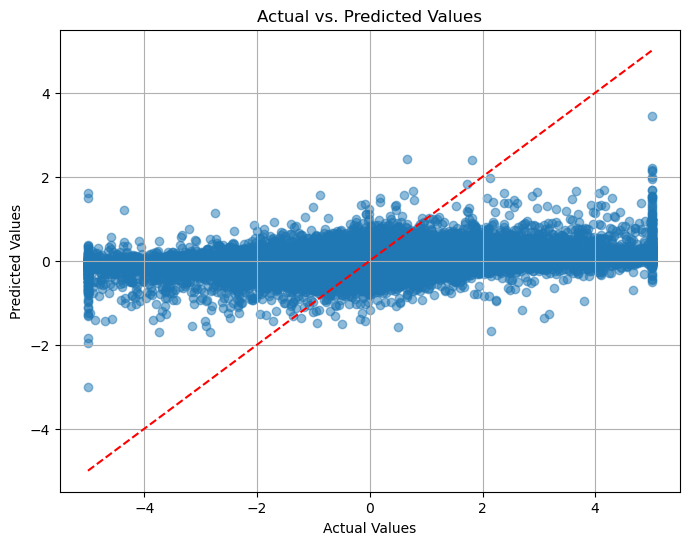

In [9]:
#  Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
plt.grid(True)
plt.show()

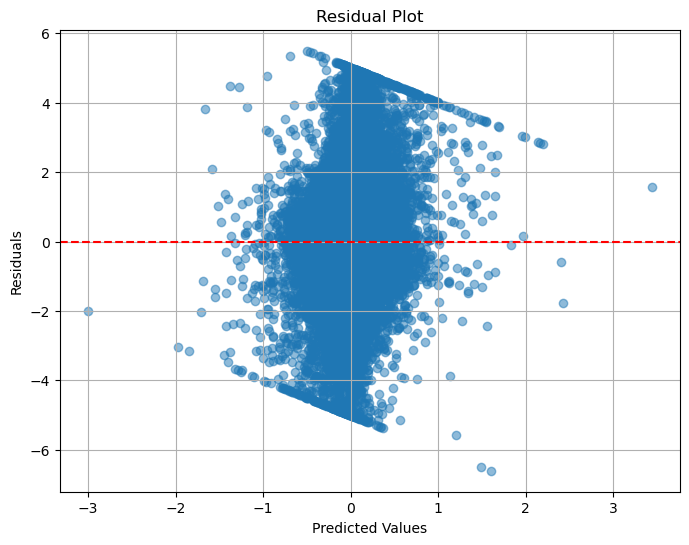

In [10]:
#  Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')  # Horizontal line at y=0
plt.grid(True)
plt.show()


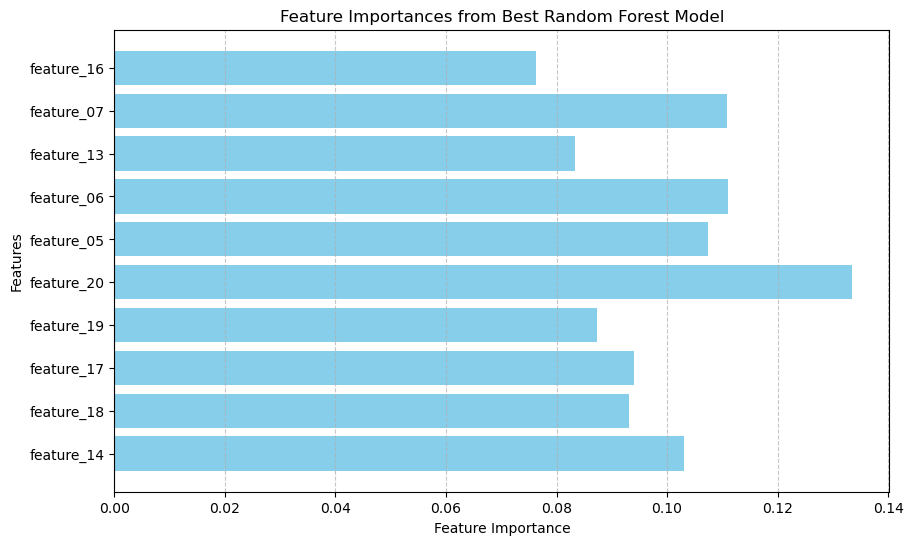

In [11]:
#  Feature Importance Plot (using the best model)
feature_importances = best_rf.feature_importances_
top_10_features_names = X.columns[top_10_indices] #get the names from the original dataframe.

plt.figure(figsize=(10, 6))
plt.barh(top_10_features_names, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Best Random Forest Model")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


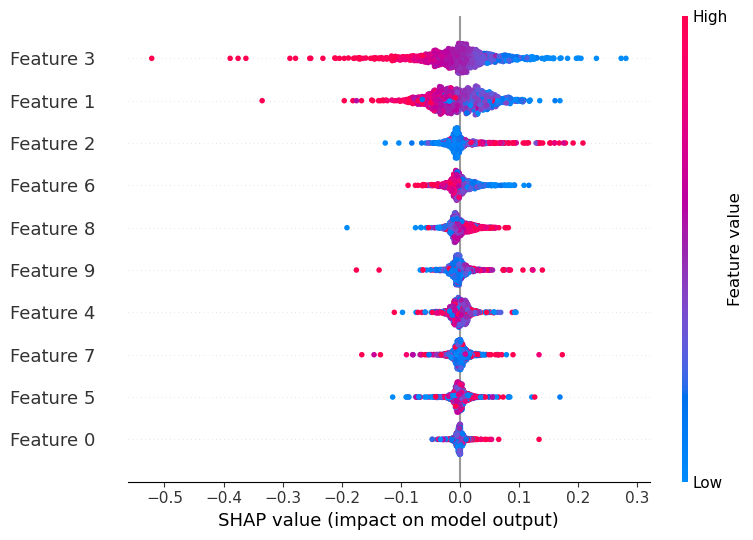

In [ ]:
#SHAP ANALYSIS
import shap

# Sample only 1000 instances from test data for SHAP computation
subset_X = shap.utils.sample(X_test_selected, 1000, random_state=42)

# Explain using TreeExplainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer(subset_X)

# Visualize
shap.summary_plot(shap_values, subset_X)
